In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define paths to data
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

# Read data
NS_SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path, 0)
CPC = read_CPC(f'{path}CPC/', parent_path)

# Define dictionary keys relavent for each experiment
CPC_dict_keys = ['test7_CPC', 'test8_CPC', 'test9_CPC', 'test10_CPC']
NS_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
APS_dict_keys = ['20241016_APS', '20241016_APS_2_exp', '20241017_APS', '20241017_APS']
SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']

# Define relevant df keys for each instrument
NS_bins = NS_SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
APS_bins = OPS_APS['20241016_APS'].keys()[1:53].to_list()
SMPS_bins = NS_SMPS['20241016_SMPS'].keys()[4:117].to_list()

# Subtract HEPA filter measurements from NanoScan data
NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              NS_SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)
for key in NS_dict_keys:
    df = NS_SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]
    NS_SMPS[key] = df

# Change OPS df keys from bin cut-point to bin mid-point
for dict_key in dict_keys:
    for old_key, new_key in zip(OPS_bins, OPS_mid_point):
        OPS_APS[dict_key] = OPS_APS[dict_key].rename(columns = {old_key: new_key})

# Convert from dN/dlogDp to N for APS
APS_bin_mean = [(0.486968 + 0.523)/2]
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean.append(float(key))
APS_cut_point = np.concatenate(([0.486968], (np.array(APS_bin_mean)[1:]+np.array(APS_bin_mean)[:-1])/2, [20.53]))

for key in APS_dict_keys[1:3]:
    for i, bin in enumerate(APS_bins):
        bin_width = np.log10(APS_cut_point[i+1]) - np.log10(APS_cut_point[i])
        OPS_APS[key][bin] = pd.to_numeric(OPS_APS[key][bin]) * bin_width

# Convert from mass to number for APS data from first experiment
APS_number = pd.DataFrame({'Time': OPS_APS['20241016_APS']['Time']})
for i, key in enumerate(APS_bins):
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce') * 1.2 # Correct density
    APS_number[key] = OPS_APS['20241016_APS'][key] / ((1.2 / 10**6) * (np.pi / 6) * APS_bin_mean[i]**3 * 10**6) # in #/cm**3
OPS_APS['20241016_APS'] = APS_number

# Convert from dN/dlogDp to N for SMPS
SMPS_bin_mean = []
for key in NS_SMPS['20241016_SMPS'].keys()[4:117]:
    SMPS_bin_mean.append(float(key) / 1000)
SMPS_cut_point = np.concatenate(([0.017], (np.array(SMPS_bin_mean)[1:]+np.array(SMPS_bin_mean)[:-1])/2, [1.0]))

for key in SMPS_dict_keys[:3]:
    for i, bin in enumerate(SMPS_bins):
        bin_width = np.log10(SMPS_cut_point[i+1]) - np.log10(SMPS_cut_point[i])
        NS_SMPS[key][bin] = pd.to_numeric(NS_SMPS[key][bin]) * bin_width

# 1 minute running mean of CPC data
CPC_running = {}
for key in CPC_dict_keys:
    df = running_mean(CPC[key], 'Conc', CPC[key].keys()[1], 'Time', '1T', 1, None)
    df['Time'] = df.index
    CPC_running[key] = df

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
LCS = read_csv(f'{path}Korrigeret low cost sensor/', parent_path, 'Time', 0, 0)

LCS0049_keys = ['2024-10-16 DG-0049', '2024-10-16 DG-0049', '2024-10-17 DG-0049', '2024-10-17 DG-0049']
LCS0051_keys = ['2024-10-16 DG-0051', '2024-10-16 DG-0051', '2024-10-17 DG-0051', '2024-10-17 DG-0051']
LCS0109_keys = ['2024-10-16 LCS109', '2024-10-16 LCS109', '2024-10-17 LCS109', '2024-10-17 LCS109']
LCS0072_keys = ['2024-10-16 DG-0072', '2024-10-16 DG-0072', '2024-10-17 DG-0072', '2024-10-17 DG-0072']
LCS0077_keys = ['2024-10-16 DG-0077', '2024-10-16 DG-0077', '2024-10-17 DG-0077', '2024-10-17 DG-0077']

LCS_df_keys = ['PN<1', 'PN<2.5', 'PN<5', 'PN<10']

In [4]:
def remove_bg(data_dict, dict_keys, new_keys, df_keys, bg_timestamps, timestamps_full):
    new_dict = {}

    for i, key in enumerate(dict_keys):
        start, end = pd.to_datetime(timestamps_full[i][0]), pd.to_datetime(timestamps_full[i][1])

        # NanoScan
        time = pd.to_datetime(data_dict[key]['Time'])
        time_filter = (time >= start) & (time <= end)
        df = data_dict[key][time_filter]

        new_df = pd.DataFrame({'Time': df['Time']})

        if len(df_keys) == 1:
            bg_time, bg_conc = time_filtered_arrays(df, None, bg_timestamps[i], df_keys[0])
            new_df[df_keys[0]] = df[df_keys[0]] - bg_conc.mean()
            new_df[df_keys[0]][new_df[df_keys[0]] < 0] = 0

        else:
            background, std, e = bin_mean(bg_timestamps[i], df, df_keys, 'Time', None)

            for bin, bg in zip(df_keys, background):
                new_df[bin] = pd.to_numeric(df[bin], errors='coerce') - bg
                new_df[bin][new_df[bin] < 0] = 0
        
        if new_keys != None:
            new_dict[new_keys[i]] = new_df
        else:
            new_dict[key] = new_df

    return new_dict

In [5]:
timestamps_BG = [['2024-10-16 10:17:00', '2024-10-16 10:26:00'],
                 ['2024-10-16 14:43:00', '2024-10-16 14:53:00'],
                 ['2024-10-17 09:48:00', '2024-10-17 09:59:00'],
                 ['2024-10-17 14:10:00', '2024-10-17 14:20:00']]

time_wBG = [['2024-10-16 10:17:00', '2024-10-16 12:50:00'],
            ['2024-10-16 14:30:00', '2024-10-16 16:30:00'],
            ['2024-10-17 09:30:00', '2024-10-17 12:10:00'],
            ['2024-10-17 14:10:00', '2024-10-17 15:30:00']]

OPS = remove_bg(OPS_APS, dict_keys, None, OPS_mid_point, timestamps_BG, time_wBG)
APS = remove_bg(OPS_APS, APS_dict_keys, dict_keys, APS_bins, timestamps_BG, time_wBG)
NS = remove_bg(NS_SMPS, NS_dict_keys, dict_keys, NS_bins, timestamps_BG, time_wBG)
SMPS = remove_bg(NS_SMPS, SMPS_dict_keys, dict_keys, SMPS_bins, timestamps_BG, time_wBG)
CPC = remove_bg(CPC_running, CPC_dict_keys, dict_keys, ['Conc'], timestamps_BG, time_wBG)

LCS0049 = remove_bg(LCS, LCS0049_keys, dict_keys, LCS_df_keys, timestamps_BG, time_wBG)
LCS0051 = remove_bg(LCS, LCS0051_keys, dict_keys, LCS_df_keys, timestamps_BG, time_wBG)
LCS0109 = remove_bg(LCS, LCS0109_keys, dict_keys, LCS_df_keys, timestamps_BG, time_wBG)
LCS0072 = remove_bg(LCS, LCS0072_keys, dict_keys, LCS_df_keys, timestamps_BG, time_wBG)
LCS0072 = remove_bg(LCS, LCS0072_keys, dict_keys, LCS_df_keys, timestamps_BG, time_wBG)

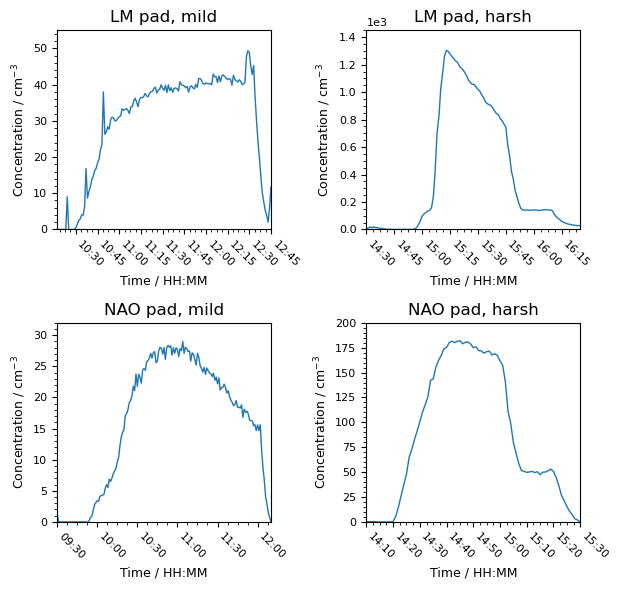

In [6]:
ymax = [55, 1450, 32, 200]
titles = ['LM pad, mild', 'LM pad, harsh', 'NAO pad, mild', 'NAO pad, harsh']

fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))

for i, ax in enumerate(axes.flatten()):
    start, end = pd.to_datetime(time_wBG[i][0]), pd.to_datetime(time_wBG[i][1])
    time_CPC = pd.to_datetime(CPC[dict_keys[i]]['Time'])
    time_filter_CPC = (time_CPC >= start) & (time_CPC <= end)
    df_CPC = CPC[dict_keys[i]][time_filter_CPC]

    plot_total(ax, df_CPC, df_CPC.keys()[1], 'tab:blue', '-')

    ax.set(ylabel = 'Concentration / cm$^{-3}$', ylim = (0, ymax[i]), title = titles[i])

fig.tight_layout()
fig.savefig('Timeseries/CPC_BWP.png', dpi = 600)

In [7]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:01:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:01:00']]

In [10]:
# Mean concentrations
for i, key in enumerate(dict_keys):
    print(f'Experiment {i+1}:')
    start, end = pd.to_datetime(timestamps_exp[i][0]), pd.to_datetime(timestamps_exp[i][1])

    # NanoScan
    time_NS = pd.to_datetime(NS[key]['Time'])
    time_filter_NS = (time_NS >= start) & (time_NS <= end)
    df_NS = NS[key][time_filter_NS]

    PN01_array_NS = df_NS.iloc[:,1:10].sum(axis = 1)
    PN03_array_NS = df_NS.iloc[:,1:13].sum(axis = 1)
    PN01_NS, PN01_STD_NS = PN01_array_NS.mean(), PN01_array_NS.std()/np.sqrt(len(PN01_array_NS))
    PN03_NS, PN03_STD_NS = PN03_array_NS.mean(), PN03_array_NS.std()/np.sqrt(len(PN03_array_NS))
    print(f'NanoScan:   PN0.1 = {PN01_NS:.2f}+-{PN01_STD_NS} and PN0.3 = {PN03_NS:.2f}+-{PN03_STD_NS}')

    # SMPS
    time_SMPS = pd.to_datetime(SMPS[key]['Time'])
    time_filter_SMPS = (time_SMPS >= start) & (time_SMPS <= end)
    df_SMPS = SMPS[key][time_filter_SMPS]

    PN01_array_SMPS = df_SMPS.iloc[:,1:51].sum(axis = 1)
    PN03_array_SMPS = df_SMPS.iloc[:,1:81].sum(axis = 1)
    PN1_array_SMPS = df_SMPS.iloc[:,1:].sum(axis = 1)
    PN01_SMPS, PN01_STD_SMPS = PN01_array_SMPS.mean(), PN01_array_SMPS.std()/np.sqrt(len(PN01_array_SMPS))
    PN03_SMPS, PN03_STD_SMPS = PN03_array_SMPS.mean(), PN03_array_SMPS.std()/np.sqrt(len(PN03_array_SMPS))
    PN1_SMPS, PN1_STD_SMPS = PN1_array_SMPS.mean(), PN1_array_SMPS.std()/np.sqrt(len(PN1_array_SMPS))
    print(f'SMPS:   PN0.1 = {PN01_SMPS:.2f}+-{PN01_STD_SMPS} and PN0.3 = {PN03_SMPS:.2f}+-{PN03_STD_SMPS} and PN1 = {PN1_SMPS:.2f}+-{PN1_STD_SMPS}')

    # CPC
    time_CPC = pd.to_datetime(CPC[key]['Time'])
    time_filter_CPC = (time_CPC >= start) & (time_CPC <= end)
    df_CPC = CPC[key][time_filter_CPC]

    PN1_CPC, PN1_STD_CPC = df_CPC['Conc'].mean(), df_CPC['Conc'].std()/np.sqrt(len(df_CPC['Conc']))
    print(f'CPC: PN1 = {PN1_CPC:.2f}+-{PN1_STD_CPC}')

    # OPS
    time_OPS = pd.to_datetime(OPS[key]['Time'])
    time_filter_OPS = (time_OPS >= start) & (time_OPS <= end)
    df_OPS = OPS[key][time_filter_OPS]

    PN1_array_OPS = df_OPS.iloc[:,1:7].sum(axis = 1)
    PN25_array_OPS = df_OPS.iloc[:,1:11].sum(axis = 1)
    PN10_array_OPS = df_OPS.iloc[:,1:].sum(axis = 1)
    PN1_OPS, PN1_STD_OPS = PN1_array_OPS.mean(), PN1_array_OPS.std()/np.sqrt(len(PN1_array_OPS))
    PN25_OPS, PN25_STD_OPS = PN25_array_OPS.mean(), PN25_array_OPS.std()/np.sqrt(len(PN25_array_OPS))
    PN10_OPS, PN10_STD_OPS = PN10_array_OPS.mean(), PN10_array_OPS.std()/np.sqrt(len(PN10_array_OPS))
    print(f'OPS:   PN1 = {PN1_OPS:.2f}+-{PN1_STD_OPS} and PN2.5 = {PN25_OPS:.2f}+-{PN25_STD_OPS} and PN10 = {PN10_OPS:.2f}+-{PN10_STD_OPS}')

    # APS
    time_APS = pd.to_datetime(APS[key]['Time'])
    time_filter_APS = (time_APS >= start) & (time_APS <= end)
    df_APS = APS[key][time_filter_APS]

    PN25_array_APS = df_APS.iloc[:,1:24].sum(axis = 1)
    PN10_array_APS = df_APS.iloc[:,1:43].sum(axis = 1)
    PN20_array_APS = df_APS.iloc[:,1:].sum(axis = 1)
    PN25_APS, PN25_STD_APS = PN25_array_APS.mean(), PN25_array_APS.std()/np.sqrt(len(PN25_array_APS))
    PN10_APS, PN10_STD_APS = PN10_array_APS.mean(), PN10_array_APS.std()/np.sqrt(len(PN10_array_APS))
    PN20_APS, PN20_STD_APS = PN20_array_APS.mean(), PN20_array_APS.std()/np.sqrt(len(PN20_array_APS))
    print(f'APS:   PN2.5 = {PN25_APS:.2f}+-{PN25_STD_APS} and PN10 = {PN10_APS:.2f}+-{PN10_STD_APS} and PN20 = {PN20_APS:.2f}+-{PN20_STD_APS}')


Experiment 1:
NanoScan:   PN0.1 = 178.28+-3.3836476788256737 and PN0.3 = 296.49+-4.831292716306572
SMPS:   PN0.1 = 2.74+-0.19794069601324257 and PN0.3 = 9.86+-0.40026245117143794 and PN1 = 26.74+-0.5877476922052236
CPC: PN1 = 37.09+-0.5076795393950484
OPS:   PN1 = 29.16+-0.38434222222153536 and PN2.5 = 32.54+-0.4079295623036141 and PN10 = 32.94+-0.4050813821273259
APS:   PN2.5 = 0.02+-0.00020424414542499108 and PN10 = 0.02+-0.0002453039110328375 and PN20 = 0.02+-0.00024524264610332965
Experiment 2:
NanoScan:   PN0.1 = 1110.11+-39.568281043209225 and PN0.3 = 1606.67+-51.237243060033116
SMPS:   PN0.1 = 364.60+-74.96501303170356 and PN0.3 = 522.94+-102.71799996737957 and PN1 = 588.35+-103.52364123653219
CPC: PN1 = 890.94+-70.4915029093552
OPS:   PN1 = 125.75+-1.4726389505448305 and PN2.5 = 139.57+-1.6092705919379509 and PN10 = 141.03+-1.6245518024319652
APS:   PN2.5 = 100.34+-0.6284766347643685 and PN10 = 111.13+-0.7806958368986965 and PN20 = 111.14+-0.7807167904864387
Experiment 3:
NanoS

In [9]:
# Total Concentrations LCS
for i, key in enumerate(dict_keys):
    print(f'Experiment {i+1}:')
    start, end = pd.to_datetime(timestamps_exp[i][0]), pd.to_datetime(timestamps_exp[i][1])

    # DG-0049
    time_0049 = pd.to_datetime(LCS0049[key]['Time'])
    time_filter_0049 = (time_0049 >= start) & (time_0049 <= end)
    df_0049 = LCS0049[key][time_filter_0049]

    PN1_0049 = df_0049['PN<1'].sum()
    PN25_0049 = df_0049['PN<2.5'].sum()
    PN10_0049 = df_0049['PN<10'].sum()
    print(f'DG-0049:   PN1 = {PN1_0049:.2f} and PN2.5 = {PN25_0049:.2f} and PN10 = {PN10_0049:.2f}')

    # DG-0051
    time_0051 = pd.to_datetime(LCS0051[key]['Time'])
    time_filter_0051 = (time_0051 >= start) & (time_0051 <= end)
    df_0051 = LCS0051[key][time_filter_0051]

    PN1_0051 = df_0051['PN<1'].sum()
    PN25_0051 = df_0051['PN<2.5'].sum()
    PN10_0051 = df_0051['PN<10'].sum()
    print(f'DG-0051:   PN1 = {PN1_0051:.2f} and PN2.5 = {PN25_0051:.2f} and PN10 = {PN10_0051:.2f}')

    # DG-0072
    time_0072 = pd.to_datetime(LCS0072[key]['Time'])
    time_filter_0072 = (time_0072 >= start) & (time_0072 <= end)
    df_0072 = LCS0072[key][time_filter_0072]

    PN1_0072 = df_0072['PN<1'].sum()
    PN25_0072 = df_0072['PN<2.5'].sum()
    PN10_0072 = df_0072['PN<10'].sum()
    print(f'DG-0072:   PN1 = {PN1_0072:.2f} and PN2.5 = {PN25_0072:.2f} and PN10 = {PN10_0072:.2f}')

Experiment 1:
DG-0049:   PN1 = 2891.44 and PN2.5 = 3216.18 and PN10 = 3279.53
DG-0051:   PN1 = 3145.21 and PN2.5 = 3457.21 and PN10 = 3532.19
DG-0072:   PN1 = 2531.61 and PN2.5 = 3060.69 and PN10 = 3198.97
Experiment 2:
DG-0049:   PN1 = 3890.73 and PN2.5 = 4381.56 and PN10 = 4461.45
DG-0051:   PN1 = 3877.47 and PN2.5 = 4315.12 and PN10 = 4418.61
DG-0072:   PN1 = 3705.02 and PN2.5 = 4534.35 and PN10 = 4751.21
Experiment 3:
DG-0049:   PN1 = 1751.74 and PN2.5 = 1996.03 and PN10 = 2027.73
DG-0051:   PN1 = 972.02 and PN2.5 = 1093.33 and PN10 = 1113.99
DG-0072:   PN1 = 1662.02 and PN2.5 = 2094.39 and PN10 = 2207.57
Experiment 4:
DG-0049:   PN1 = 2909.66 and PN2.5 = 3490.92 and PN10 = 3560.07
DG-0051:   PN1 = 2908.24 and PN2.5 = 3437.53 and PN10 = 3522.06
DG-0072:   PN1 = 3400.87 and PN2.5 = 4374.85 and PN10 = 4629.95
